# House Prices Prediction (Ames, Iowa, USA)

## 1. Problem Statement
This project aims at predicting house prices in Ames, Iowa, USA. 

#### Import Library

In [1]:
# Importing  libraries
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
#plt.rcParams['figure.figsize'] = (12.0, 8.0)

from sklearn.preprocessing import StandardScaler
from scipy import stats

# Machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, Ridge, Lasso


from sklearn.model_selection import GridSearchCV
from mlxtend.regressor import StackingCVRegressor
from sklearn.pipeline import make_pipeline
from lightgbm import LGBMRegressor
import lightgbm as lgb
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Ridge, RidgeCV, ElasticNetCV
from sklearn.preprocessing import RobustScaler
from sklearn.svm import SVR

## 2. Data Exploration

In [2]:
# Read in the dataset as a dataframe
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.shape, test.shape

((1460, 81), (1459, 80))

In [3]:
# Take a look at dataset
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


There are null values present in the dataset, but all of them are not completely random, some null values are present on purpose to denote that the house don't have that feature

In [4]:
# take a look at info
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [5]:
# check column of train and test are same
set(train.columns) - set(test.columns)

{'SalePrice'}

Out of 81 features, 19 features have missing values. 
Fence, Alley, MiscFeature, PoolQC have more than 80% of null values. It is genreally consider as not useful to keep while analysing data sets, but if we look at feature description, it is clear that not all are random null values. so we gonna keep this feature and carefully deal with null values.

In [6]:
# check missing values
missing_values = (train.isnull().sum()[train.isnull().sum() > 0]/len(train)).to_frame(name='percent')
missing_values = missing_values.sort_values(by='percent')
missing_values

,percent
Electrical,0.000685
MasVnrType,0.005479
MasVnrArea,0.005479
BsmtQual,0.025342
BsmtCond,0.025342
BsmtFinType1,0.025342
BsmtExposure,0.026027
BsmtFinType2,0.026027
GarageCond,0.055479
GarageQual,0.055479


#### Graphing Missing values

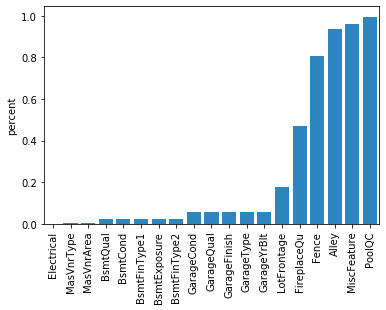

In [7]:
# Graph missing values
sns.barplot(x=missing_values.index, y="percent", data=missing_values, color="#2E86C1", saturation=1)
plt.xticks(rotation = 90)
plt.show()

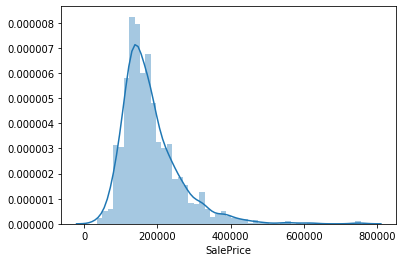

In [8]:
#SalePrice
sns.distplot(train['SalePrice'])
plt.show()

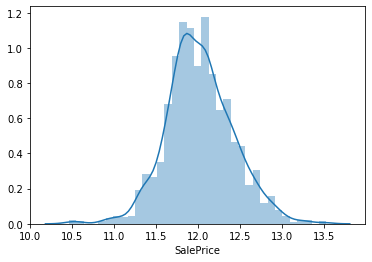

In [9]:
# Taking log to saleprice
train_target = np.log(train['SalePrice'])
sns.distplot(train_target)
plt.show()

In [10]:
#separate variables into new data frames
numeric_data = train.select_dtypes(include=[np.number])
cat_data = train.select_dtypes(exclude=[np.number])
print ("{} numeric and {} categorical columns in train data".format(
    numeric_data.shape[1],cat_data.shape[1]))

38 numeric and 43 categorical columns in train data


#### Correlation heat map
The correlation heat map show good picture about how each variables are correlated with each others. some interesting correlated variables are (GarageYrBlt Vs YearBuilt)(GrLivArea Vs TotRmsAbvGrd)(GarageArea Vs GarageCars)

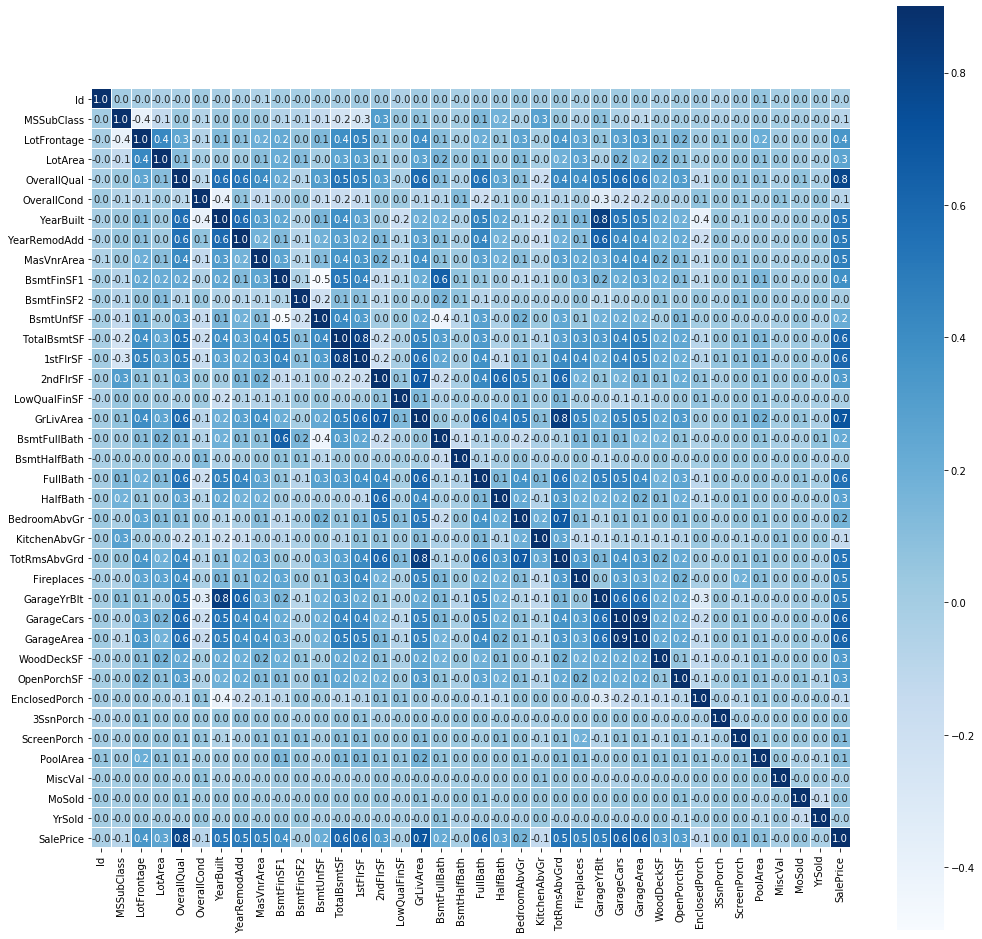

In [11]:
plt.subplots(figsize=(17,17))
sns.heatmap(numeric_data.corr(), vmax=0.9, square=True, cmap="Blues", annot=True, fmt='.1f', linewidth='.1')
plt.show()

#### Correlation with Target variable
Below Graph show correlation between housing data features and traget variable, some interesting patten to note are correlation between SalePrice Vs (TotalBsmtSF, GrLivArea, 1stFlrSF, BsmtFinSF1, 2stFlrSF)

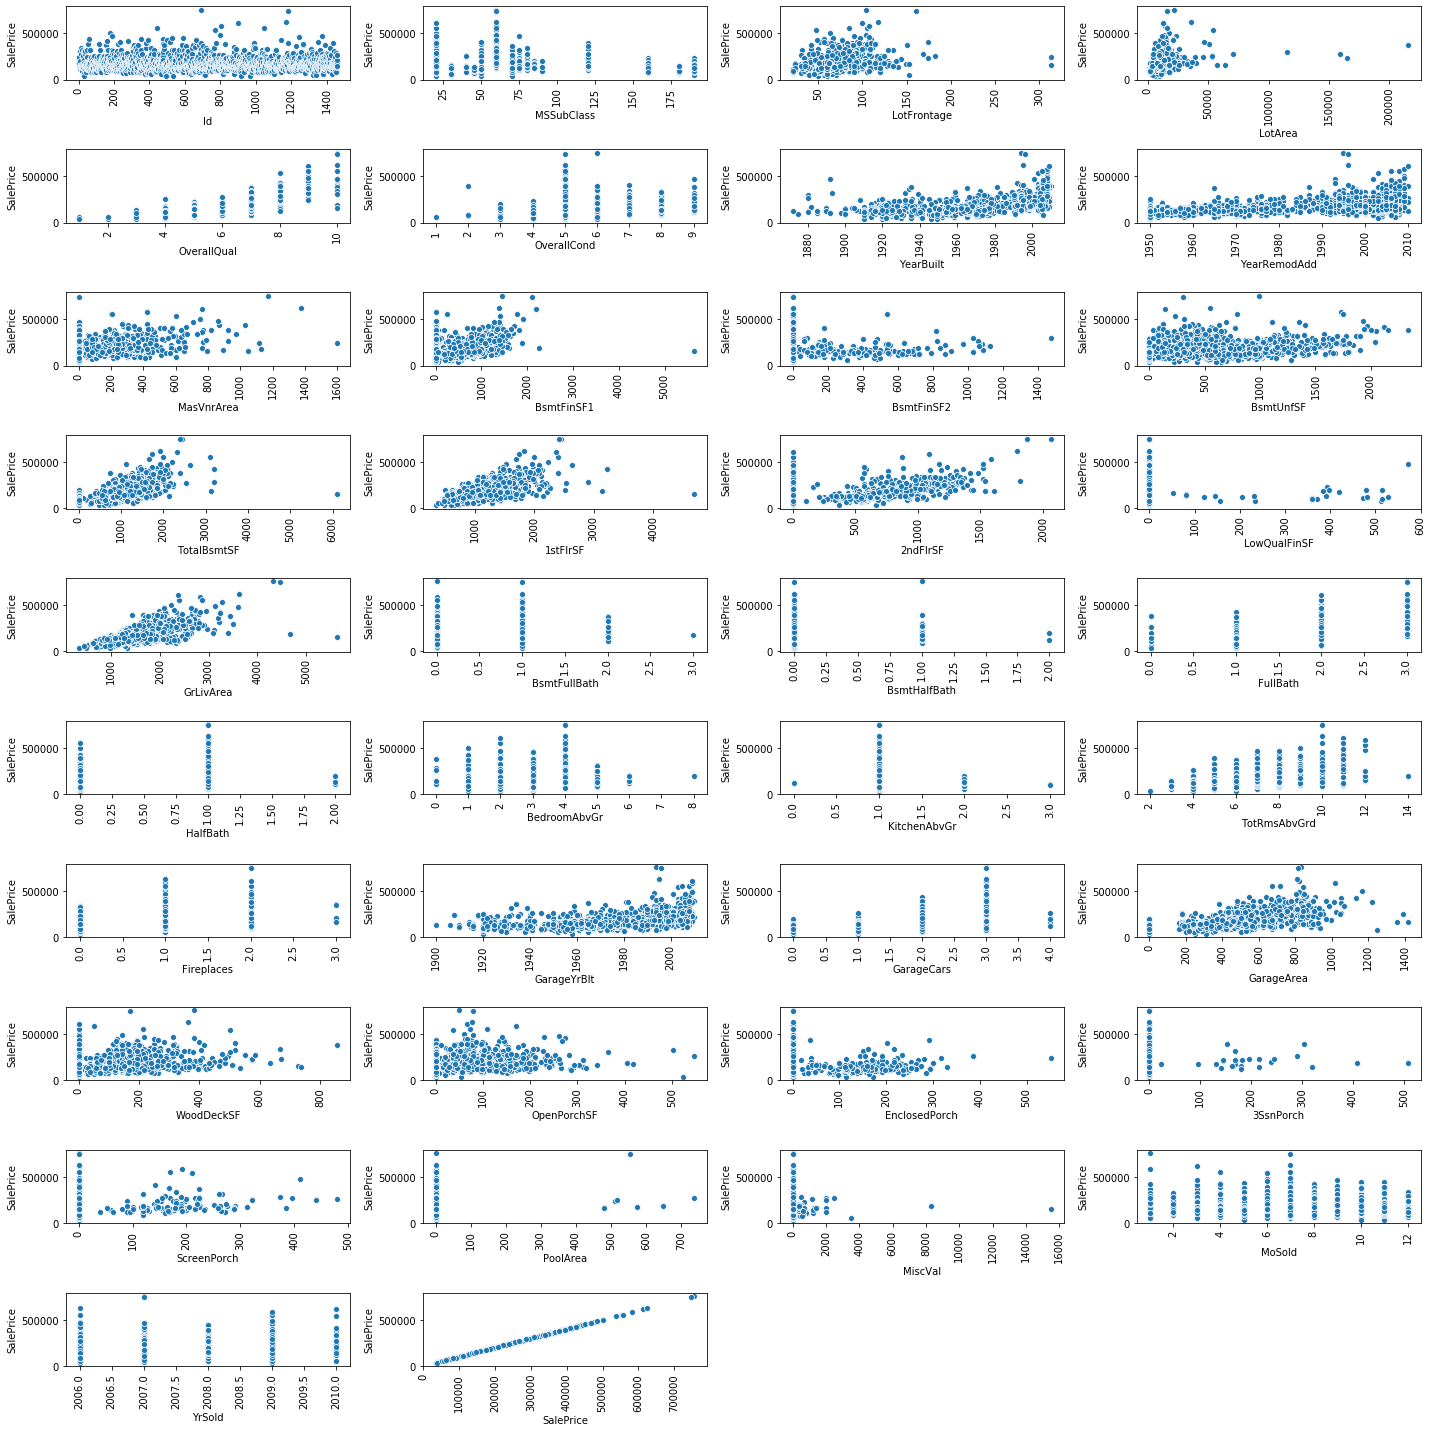

In [12]:
fig, axs = plt.subplots(figsize=(20, 20))
axs.axis('off')
for i, col_name in enumerate(numeric_data.columns):
    fig.add_subplot( int((numeric_data.shape[1]/4)+1) , 4, i+1)
    sns.scatterplot(data=numeric_data, x=col_name, y='SalePrice')
    plt.xlabel(col_name)
    plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

###### Note:
Even though all are numeric values some values are rating so those variable should be categorical 
1. MSSubClass
2. OverallQual
3. OverallCond
4. YearBuilt
5. YearRemodAdd
6. BsmtFullBath
7. BsmtHalfBath
8. FullBath
9. HalfBath
10. BedroomAbvGr
11. KitchenAbvGr
12. TotRmsAbvGrd
13. Fireplaces
14. GarageCars
15. MoSold
16. YrSold

In [13]:
cat_data = cat_data.join(numeric_data[['MSSubClass', 'OverallQual', 'OverallCond', 'YearBuilt', 
                                              'YearRemodAdd', 'BsmtFullBath', 'BsmtHalfBath', 
         'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 
         'MoSold', 'YrSold', 'SalePrice']], how='outer')

#### Comparing Categorical variable with SalesPrice
There are lot of intresting pattern, amoung those the few notable variables are OverallQual, HeatingQC, Electrical,
HouseStyle, CentralAir, TotRmsAbvGrd <br/>
OverallQual (Ordinal variable) clearly shows diffenence as Quality rating increases the median value increases.
HeatingQC (Ordinal variable) clearly shows as Quality rating increases the median value increases.
Electrical shows difference in median salesprice with different type of electrical
<br/>
The other things to note is MoSold, Yrsold did not show much difference

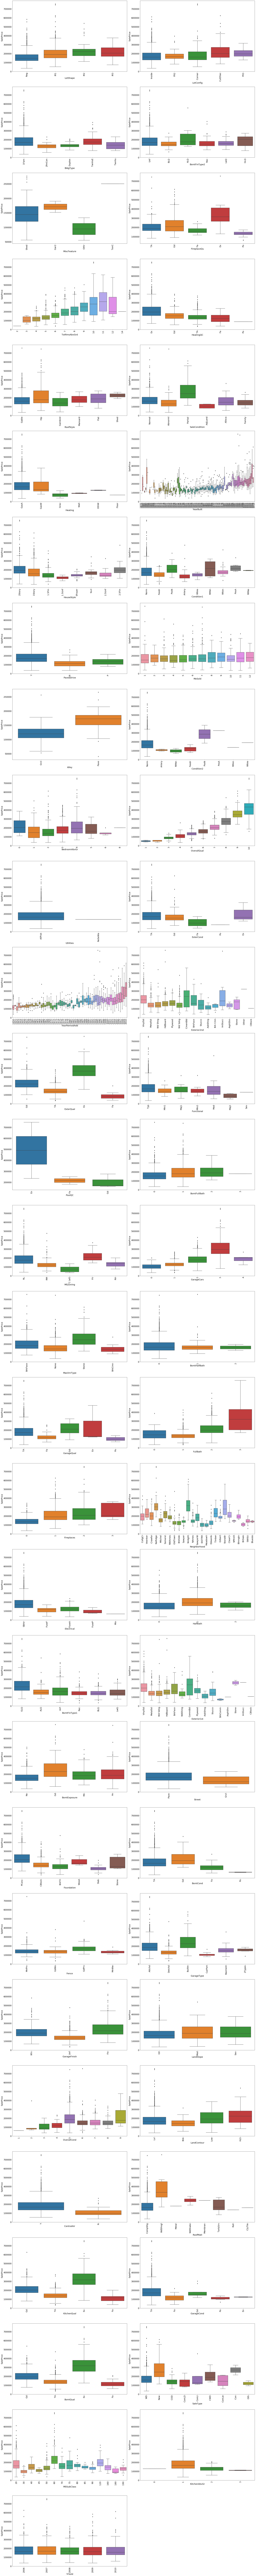

In [14]:
#fig, axs = plt.subplots(figsize=(60, 180))
fig = plt.figure(figsize=(30,600))
axs.axis('off')
#fig = plt.gcf()
#fig.set_size_inches(20, 30)
for i, col_name in enumerate(set(cat_data.columns) - set(['SalePrice'])):
    fig.add_subplot( cat_data.shape[1] ,2, i+1)
    sns.boxplot(data=cat_data, x=col_name, y='SalePrice')
    plt.xlabel(col_name, fontsize=18)
    plt.ylabel('SalePrice',fontsize=18)
    plt.xticks(rotation=90, fontsize=18)
    plt.yticks(rotation=0, fontsize=18)
plt.tight_layout()
plt.show()

#### Significant of Categorical Variable
The Box plot show good understanding about categorical variable, but to understand significance of those variable performing ANOVA test is helpful. <br/>
Ho (Null Hypothesis) - There exists no significant difference between the groups. <br/>
Ha (Alternate Hypothesis) - There exists a significant difference between the groups. <br/>
It is clear from the plot that Neighborhood plays import role in determining the salesprice, which is not feature of house itself, But variables kitchenQual, FullBath are features of house and it plays main role in salesprice

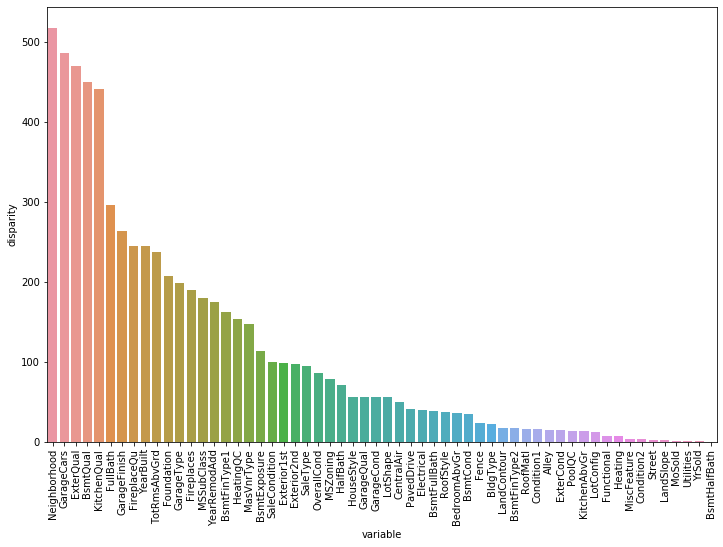

In [15]:
# ANOVA test
# Ho (Null Hypothesis) - There exists no significant difference between the groups. 
# Ha (Alternate Hypothesis) - There exists a significant difference between the groups.
cat_col = (set(cat_data.columns) - set(['SalePrice','OverallQual']))
anova_variable = []
anova_disparity = []
for cat in cat_col:
    groups = []
    cat_data[cat] = cat_data[cat].astype(str)
    for u_val in cat_data[cat].unique():
        groups.append( cat_data[cat_data[cat] == u_val]["SalePrice"].values )
    pval = stats.f_oneway(*groups)[1]
    #anova_dict[cat] = np.log(1/pval)
    anova_variable.append(cat)
    anova_disparity.append(np.log(1/pval))
anova_df = pd.DataFrame({'variable':anova_variable, 'disparity':anova_disparity})
anova_df = anova_df.sort_values(by='disparity', ascending=False,ignore_index=True)
fig = plt.figure(figsize=(12,8))
sns.barplot(data=anova_df, x='variable', y='disparity')
plt.xticks(rotation=90) 
plt.show()

## 3. Data Pre-Processing

### Handling NULL values AND Feature Engineering

##### Numeric Values
LotFrontage, LotArea, MasVnrArea, BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, 1stFlrSF, 2ndFlrSF, LowQualFinSF,
GrLivArea, GarageArea, WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch, PoolArea, MiscVal

##### Ordinal Values
OverallQual, OverallCond, ExterQual, ExterCond, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2,
HeatingQC, KitchenQual, FireplaceQu, GarageQual, GarageCond, PoolQC, BsmtFullBath, BsmtHalfBath, FullBath,
HalfBath, BedroomAbvGr, KitchenAbvGr, TotRmsAbvGrd, Fireplaces, GarageCars, YearBuilt, YearRemodAdd,
GarageYrBlt, YrSold, MoSold

##### Nominal Values
MSSubClass, MSZoning, Alley, LotShape, LandContour, Utilities, LotConfig, LandSlope, Neighborhood, Condition1,
Condition2, BldgType, HouseStyle, RoofStyle, RoofMatl, Exterior1st, Exterior2nd, MasVnrType, Foundation,
Heating, Electrical, Functional, GarageType, GarageFinish, PavedDrive, Fence, MiscFeature, SaleType,
SaleCondition, Street, CentralAir

In [16]:
numeric_features = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 
                    '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 
                    'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']

category_ordinal_features = ['OverallQual', 'OverallCond', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 
                             'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'KitchenQual', 
                             'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC', 'BsmtFullBath', 'BsmtHalfBath', 
                             'FullBath', 'HalfBath','BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 
                             'GarageCars', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold', 'MoSold']

category_nominal_features = ['MSSubClass', 'MSZoning', 'Alley', 'LotShape', 'LandContour', 'Utilities', 
                             'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 
                             'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 
                             'Foundation', 'Heating', 'Electrical', 'Functional', 'GarageType', 'GarageFinish', 
                             'PavedDrive', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition', 'Street', 
                             'CentralAir']


##### Handling MNAR (Missing Not At Random)
Alley [NA 	No alley access]

BsmtQual [NA   No Basement]<br/>
BsmtCond [NA	No Basement]<br/>
BsmtExposure [NA	No Basement] [No	No Exposure]<br/>
BsmtFinType1 [NA	No Basement] --- BsmtFinSF1<br/>
BsmtFinType2 [NA	No Basement] --- BsmtFinSF2<br/>
[BsmtUnfSF, TotalBsmtSF, BsmtFullBath, BsmtHalfBath]<br/>
<br/>
FireplaceQu [NA	No Fireplace]<br/>
[Fireplaces]<br/>
<br/>
GarageType [NA	No Garage]<br/>
GarageFinish [NA	No Garage]<br/>
GarageQual [NA	No Garage]<br/>
GarageCond [NA	No Garage]<br/>
[GarageYrBlt, GarageCars, GarageArea ]<br/>
<br/>
PoolQC [NA	No Pool]<br/>
[PoolArea]<br/>
<br/>
Fence [NA	No Fence]<br/>
<br/>
MiscFeature [NA	None]<br/>
[MiscVal]<br/>

#### Handling NULL Values

Replace all null value to None, since this dataset contains null value not at random

In [17]:
#Alley [NA - No alley access][nominal]
train.loc[train['Alley'].isna(),'Alley' ] = 'None'
test.loc[test['Alley'].isna(),'Alley' ] = 'None'

#GarageType [NA   No Garage] [nominal]
train.loc[train['GarageType'].isna(),'GarageType' ] = 'None'
test.loc[test['GarageType'].isna(),'GarageType' ] = 'None'

#GarageFinish [NA   No Garage] [nominal]
train.loc[train['GarageFinish'].isna(),'GarageFinish' ] = 'None'
test.loc[test['GarageFinish'].isna(),'GarageFinish' ] = 'None'

#Fence [NA   No Garage] [nominal]
train.loc[train['Fence'].isna(),'Fence' ] = 'None'
test.loc[test['Fence'].isna(),'Fence' ] = 'None'

#MiscFeature [NA  None][nominal]
train.loc[train['MiscFeature'].isna(),'MiscFeature' ] = 'None'
test.loc[test['MiscFeature'].isna(),'MiscFeature' ] = 'None'

Replace Ordinal variables to with numerical values with order, so it is easy for model to handel

In [18]:
#BsmtQual [NA   No Basement][ordinal]
BsmtQual_map = {'Ex':5, 'Gd':4,  'TA':3, 'Fa':2, 'Po':1, np.nan:0}
train["BsmtQual"] = train["BsmtQual"].map(BsmtQual_map)
test["BsmtQual"] = test["BsmtQual"].map(BsmtQual_map)

#BsmtCond [NA    No Basement][ordinal]
BsmtCond_map = {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, np.nan:0}
train["BsmtCond"] = train["BsmtCond"].map(BsmtCond_map)
test["BsmtCond"] = test["BsmtCond"].map(BsmtCond_map)

#BsmtExposure [NA    No Basement] [No    No Exposure][ordinal]
BsmtExposure_map = {'Gd':4, 'Av':3, 'Mn':2, 'No':1, np.nan:0}
train["BsmtExposure"] = train["BsmtExposure"].map(BsmtExposure_map)
test["BsmtExposure"] = test["BsmtExposure"].map(BsmtExposure_map)

#BsmtFinType1 [NA    No Basement] --- BsmtFinSF1 [ordinal]
BsmtFinType1_map = {'GLQ':6, 'ALQ':5, 'BLQ':4, 'Rec':3, 'LwQ':2, 'Unf':1, np.nan:0}
train["BsmtFinType1"] = train["BsmtFinType1"].map(BsmtFinType1_map)
test["BsmtFinType1"] = test["BsmtFinType1"].map(BsmtFinType1_map)

#BsmtFinType2 [NA    No Basement] --- BsmtFinSF2 [ordinal]
BsmtFinType2_map = {'GLQ':6, 'ALQ':5, 'BLQ':4, 'Rec':3, 'LwQ':2, 'Unf':1, np.nan:0}
train["BsmtFinType2"] = train["BsmtFinType2"].map(BsmtFinType2_map)
test["BsmtFinType2"] = test["BsmtFinType2"].map(BsmtFinType2_map)

#FireplaceQu [NA    No Fireplace] [ordinal]
FireplaceQu_map = {'Ex':5, 'Gd':4, 'TA':3}
train["FireplaceQu"] = train["FireplaceQu"].map(FireplaceQu_map)
test["FireplaceQu"] = test["FireplaceQu"].map(FireplaceQu_map)

#GarageQual [NA    No Garage] [ordinal]
GarageQual_map = {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, np.nan:0}
train["GarageQual"] = train["GarageQual"].map(GarageQual_map)
test["GarageQual"] = test["GarageQual"].map(GarageQual_map)

#GarageCond [NA    No Garage] [ordinal]
GarageCond_map = {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, np.nan:0}
train["GarageCond"] = train["GarageCond"].map(GarageCond_map)
test["GarageCond"] = test["GarageCond"].map(GarageCond_map)

#PoolQC [NA    No Pool] [ordinal]
PoolQC_map = {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, np.nan:0}
train["PoolQC"] = train["PoolQC"].map(PoolQC_map)
test["PoolQC"] = test["PoolQC"].map(PoolQC_map)


In [19]:
#ExterQual - [ordinal]
ExterQual_map = {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1}
train["ExterQual"] = train["ExterQual"].map(ExterQual_map)
test["ExterQual"] = test["ExterQual"].map(ExterQual_map)

#ExterCond - [ordinal]
ExterCond_map = {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1}
train["ExterCond"] = train["ExterCond"].map(ExterCond_map)
test["ExterCond"] = test["ExterCond"].map(ExterCond_map)

#HeatingQC - [ordinal]
HeatingQC_map = {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1}
train["HeatingQC"] = train["HeatingQC"].map(HeatingQC_map)
test["HeatingQC"] = test["HeatingQC"].map(HeatingQC_map)

#KitchenQual - [ordinal]
KitchenQual_map = {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1}
train["KitchenQual"] = train["KitchenQual"].map(KitchenQual_map)
test["KitchenQual"] = test["KitchenQual"].map(KitchenQual_map)


In [20]:
# Taking care of ordinal NULL variable by Mode
def handling_ordinal_features(df):
    for ord_var in category_ordinal_features:
        try:
            df[ord_var] = (df.groupby(['Neighborhood'])
                                          [ord_var].apply(lambda x: x.fillna(x.value_counts().index[0])))
        except IndexError as error:
            df[ord_var] = (df[ord_var].fillna(train[ord_var].mode()[0]))
    return df

In [21]:
train = handling_ordinal_features( train )
test = handling_ordinal_features( test )

In [22]:
# Taking care of nominal NULL variable by Mode
def handling_nominal_features(df):
    for ord_var in category_nominal_features:
        try:
            df[ord_var] = (df.groupby(['Neighborhood'])
                                          [ord_var].apply(lambda x: x.fillna(x.value_counts().index[0])))
        except IndexError as error:
            df[ord_var] = (df[ord_var].fillna(train[ord_var].mode()[0]))
    return df

In [23]:
train = handling_nominal_features( train )
test = handling_nominal_features( test )

Making sure that if some feature not present, then it's surface area should be zero

In [24]:
#BsmtQual [ordinal] // [BsmtUnfSF, TotalBsmtSF] [numerical] // [make basement area = 0, if bsmtqual = 0]
train.loc[train['BsmtQual'] ==  0,'BsmtUnfSF' ] = 0.0
test.loc[test['BsmtQual'] == 0,'BsmtUnfSF' ] = 0.0

train.loc[train['BsmtQual'] ==  0,'TotalBsmtSF' ] = 0.0
test.loc[test['BsmtQual'] == 0,'TotalBsmtSF' ] = 0.0

#GarageQual // [ GarageArea ] [numerical] // [make garage area = 0, if GarageQual = 0]
train.loc[train['GarageQual'] ==  0,'GarageArea' ] = 0.0
test.loc[test['GarageQual'] == 0,'GarageArea' ] = 0.0

#PoolQC // [PoolArea] [numerical] // [make pool area = 0, if poolQC = 0]
train.loc[train['PoolQC'] ==  0,'PoolArea' ] = 0.0
test.loc[test['PoolQC'] == 0,'PoolArea' ] = 0.0

#MiscFeature // [MiscVal][numerical] // [make MiscVal=0, if MiscFeature=None]
train.loc[train['MiscFeature'] == 'None','MiscVal' ] = 0.0
test.loc[test['MiscFeature'] == 'None','MiscVal' ] = 0.0

#MasVnrType // [MasVnrArea][numerical] // [make MasVnrArea=0, if MasVnrType=None]
train.loc[train['MasVnrType'] == 'None','MasVnrArea' ] = 0.0
test.loc[test['MasVnrType'] == 'None','MasVnrArea' ] = 0.0

In [25]:
# Taking care of Numerical NULL variable by Median
def handling_numerical_features(df):
    for ord_var in numeric_features:
        try:
            df[ord_var] = (df.groupby(['Neighborhood'])
                                          [ord_var].apply(lambda x: x.fillna(x.median())))
        except IndexError as error:
            df[ord_var] = (df[ord_var].fillna(train[ord_var].median()))
    return df

In [26]:
train = handling_numerical_features( train )
test = handling_numerical_features( test )

### Feature Engineering

In [27]:
#calculating total area using all area columns
area_cols = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
             'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF',
             'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'LowQualFinSF', 'PoolArea' ]

train["TotalArea"] = train[area_cols].sum(axis=1)
train["TotalArea1st2nd"] = train["1stFlrSF"] + train["2ndFlrSF"]
train["Age"] = 2010 - train["YearBuilt"]

test["TotalArea"] = test[area_cols].sum(axis=1)
test["TotalArea1st2nd"] = test["1stFlrSF"] + test["2ndFlrSF"]
test["Age"] = 2010 - test["YearBuilt"]

#train['TotalSF'] = train['TotalBsmtSF'] + train['2ndFlrSF']
#test['TotalSF'] = test['TotalBsmtSF'] + test['2ndFlrSF']

train['TotalBath'] = train['BsmtFullBath'] + train['BsmtHalfBath'] + train['FullBath'] + train['HalfBath']
test['TotalBath'] = test['BsmtFullBath'] + test['BsmtHalfBath'] + test['FullBath'] + test['HalfBath']


train['PorchSF'] = train['OpenPorchSF'] + train['EnclosedPorch'] + train['3SsnPorch'] + train['ScreenPorch'] + train['WoodDeckSF']
test['PorchSF'] = test['OpenPorchSF'] + test['EnclosedPorch'] + test['3SsnPorch'] + test['ScreenPorch'] + test['WoodDeckSF']

# train data
train['HasBsmt'] = train['TotalBsmtSF'].apply(lambda x: 1 if x>0 else 0)
train['HasPool'] = train['PoolArea'].apply(lambda x: 1 if x>0 else 0)
train['Has2ndFlr'] = train['2ndFlrSF'].apply(lambda x: 1 if x>0 else 0)
train['HasFirePlace'] = train['Fireplaces'].apply(lambda x: 1 if x>0 else 0)
train['HasGarage'] = train['GarageCars'].apply(lambda x: 1 if x>0 else 0)

# test data
test['HasBsmt'] = test['TotalBsmtSF'].apply(lambda x: 1 if x>0 else 0)
test['HasPool'] = test['PoolArea'].apply(lambda x: 1 if x>0 else 0)
test['Has2ndFlr'] = test['2ndFlrSF'].apply(lambda x: 1 if x>0 else 0)
test['HasFirePlace'] = test['Fireplaces'].apply(lambda x: 1 if x>0 else 0)
test['HasGarage'] = test['GarageCars'].apply(lambda x: 1 if x>0 else 0)

# Convert All Numerical to "float"
# Convert All Ordinal to "int"
# Convert All Nominal to "dummy_onehot_encoding"

In [28]:
# Convert All Numerical to "float"
train[numeric_features] = train[numeric_features].astype('float')
test[numeric_features] = test[numeric_features].astype('float')

In [29]:
# Convert All Ordinal to "int"
train[category_ordinal_features] = train[category_ordinal_features].astype('int')
test[category_ordinal_features] = test[category_ordinal_features].astype('int')

In [30]:
# Convert All Nominal to "onehot_encoding"
# Create the encoder.
encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)
encoder.fit(train[category_nominal_features])

OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
              handle_unknown='ignore', sparse=False)

In [31]:
# Transforming train dataset (nominal)
train_nominal_ohe = pd.DataFrame(encoder.transform(train[category_nominal_features])) 
train_nominal_ohe.columns = encoder.get_feature_names(category_nominal_features)
train.drop(category_nominal_features ,axis=1, inplace=True)
train = pd.concat([train, train_nominal_ohe ], axis=1)
#train = train.join(train_nominal_ohe)
# Transforming train dataset (ordinal)
test_nominal_ohe = pd.DataFrame(encoder.transform(test[category_nominal_features])) 
test_nominal_ohe.columns = encoder.get_feature_names(category_nominal_features)
test.drop(category_nominal_features ,axis=1, inplace=True)
test = pd.concat([test, test_nominal_ohe ], axis=1)
#test = test.join(test_nominal_ohe)

In [32]:
# #removing outliers
train = train.drop(train[train['GrLivArea'] > 4000].index).reset_index()

In [33]:
#train = train.drop(['Id'], axis=1)
train = (train.drop(['Id'], axis=1) if 'Id' in train.columns else train)
train = (train.drop(['index'], axis=1) if 'index' in train.columns else train)
test = (test.drop(['Id'], axis=1) if 'Id' in test.columns else test)
#train.Id

In [34]:
train.shape, test.shape

((1456, 271), (1459, 270))

In [35]:
# log the saleprice
# Taking log to saleprice
target = np.log1p(train['SalePrice'])

In [36]:
def rev_y(trans_y):
    return np.expm1(trans_y)

#### viewing variables after removing outliers

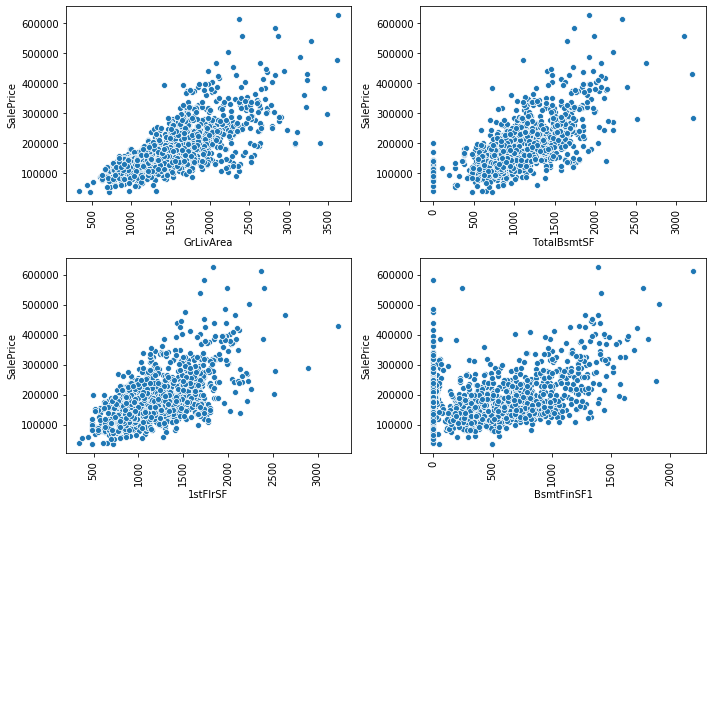

In [37]:
# viewing variables after removing outliers
fig, axs = plt.subplots(figsize=(10, 10))
axs.axis('off')
for i, col_name in enumerate(['GrLivArea','TotalBsmtSF','1stFlrSF','BsmtFinSF1']):
    fig.add_subplot( int((4/2)+1) , 2, i+1)
    sns.scatterplot(data=train, x=col_name, y='SalePrice')
    plt.xlabel(col_name)
    plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

#### viewing newly created variables

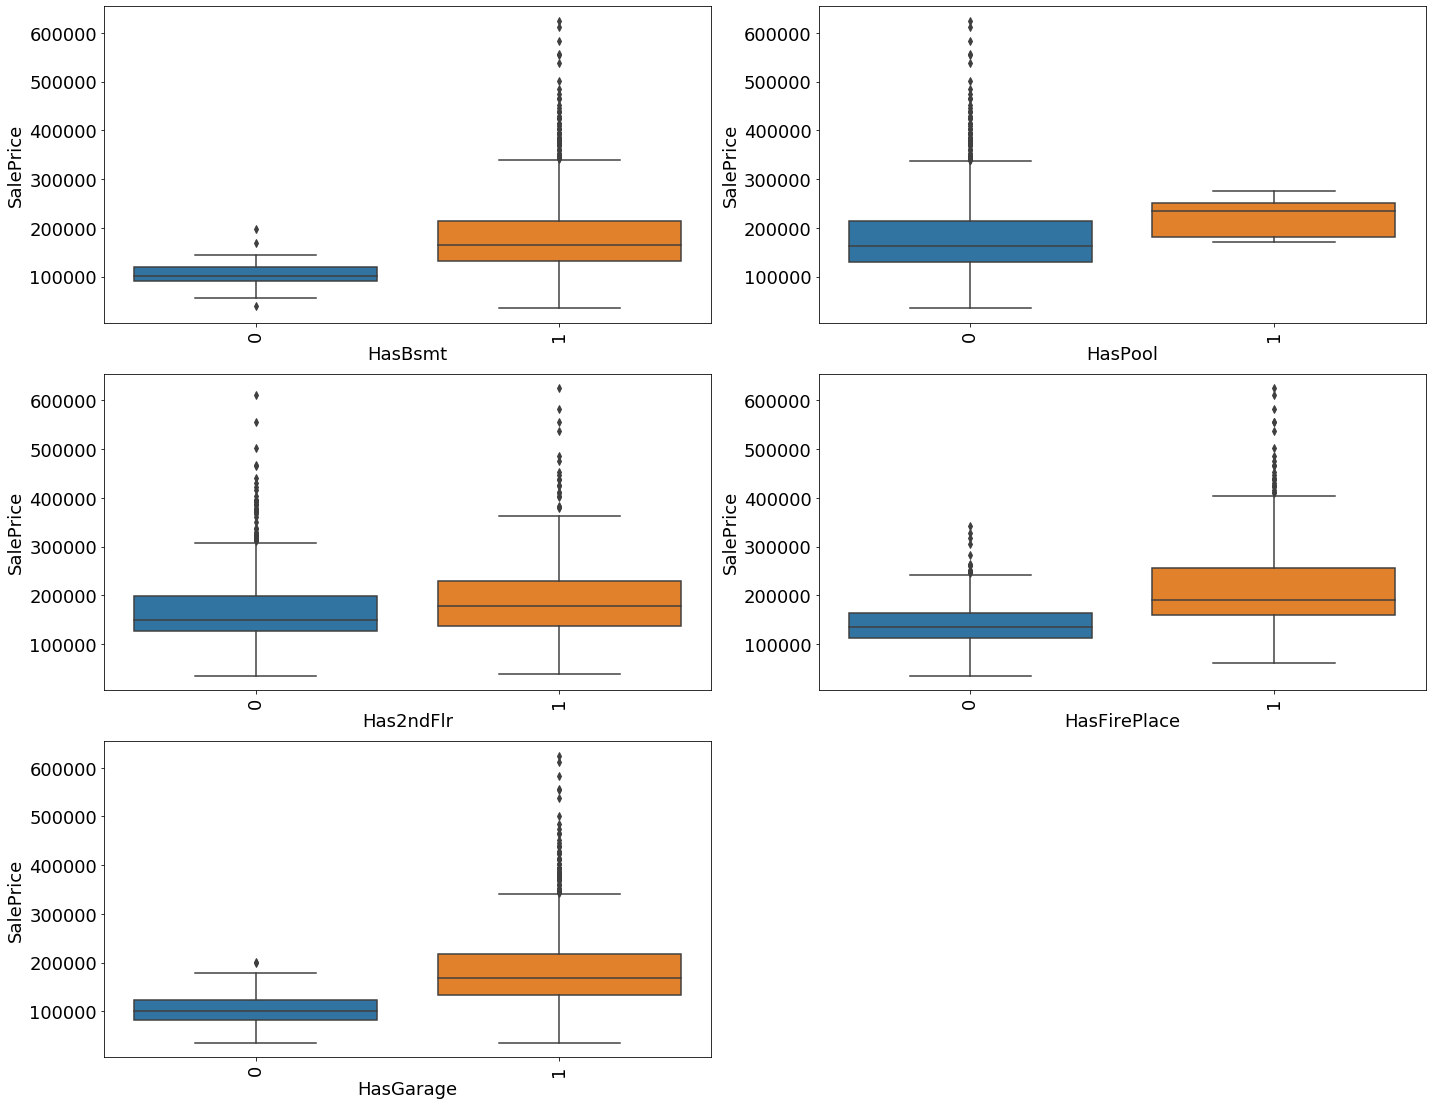

In [38]:
# Viewing Newly created Variable
fig = plt.figure(figsize=(20,20))
axs.axis('off')
for i, col_name in enumerate(['HasBsmt', 'HasPool', 'Has2ndFlr', 'HasFirePlace', 'HasGarage']):
    fig.add_subplot( int((6/2)+1) ,2, i+1)
    sns.boxplot(data=train, x=col_name, y='SalePrice')
    plt.xlabel(col_name, fontsize=18)
    plt.ylabel('SalePrice',fontsize=18)
    plt.xticks(rotation=90, fontsize=18)
    plt.yticks(rotation=0, fontsize=18)
plt.tight_layout()
plt.show()

## 4. Modeling

In [39]:
# Perform train test split on this data

X = train.drop(['SalePrice'], axis=1)
y = target

In [40]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=2)

In [41]:
X_train.shape, X_valid.shape

((1164, 270), (292, 270))

#### Gride Search

In [42]:
# #XGBoost
# params = {
#     'n_estimators' : np.arange(3000, 4500, 500),
#     'objective':['reg:squarederror'],
#     'learning_rate' : np.arange(0.01,0.1,0.01),
#     'colsample_bytree' : np.arange(0.4, 0.6, 0.05),
#     'max_depth' : np.arange(2,5,1),
#     'gamma' : np.arange(0,0.3,0.1),
#     'subsample' : np.arange(0.3,0.6,0.1),
#     'reg_alpha':np.arange(0,0.4,0.1),
#     'reg_lambda':np.arange(0,4,1)   
# }
# model_xgb = XGBRegressor()


# # Fit the model and run GridSearchCV
# gs_xgb = GridSearchCV(estimator = model_xgb, param_grid = params)
# gs_xgb.fit(X_train, y_train)

# # Store value in variable
# #n_estimators_ =  gs.best_params_['n_estimators']

# # What is the final selection for n_estimators?
# print ("XGB Best Parameters:", gs_xgb.best_params_)

### Final Model

In [43]:
n = 3500

# Linear Regression
lnr = make_pipeline(RobustScaler(), LinearRegression())

# XGBoost Regressor
xgb = XGBRegressor(n_estimators=n,
                   learning_rate=0.01,
                   colsample_bytree=0.45,
                   max_depth=3,
                   gamma=0,
                   subsample=0.4,
                   reg_alpha=0,
                   reg_lambda=1,
                   objective='reg:squarederror')

# Light Gradient Boosting Regressor
lgb = LGBMRegressor(objective='regression', 
                       num_leaves=6,
                       learning_rate=0.01, 
                       n_estimators=n,
                       max_bin=200, 
                       bagging_fraction=0.8,
                       bagging_freq=4, 
                       bagging_seed=8,
                       feature_fraction=0.2,
                       feature_fraction_seed=8,
                       min_sum_hessian_in_leaf = 11,
                       verbose=-1,
                       random_state=42)

# Ridge Regressor
ridge_alphas = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=ridge_alphas))

# ElasticNet Regressor
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]
elasticnet = make_pipeline(RobustScaler(), ElasticNetCV(max_iter=1e7, alphas=e_alphas, l1_ratio=e_l1ratio))

# Support Vector Regressor
svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003))

# Gradient Boosting Regressor
gbr = GradientBoostingRegressor(n_estimators=n,
                                learning_rate=0.01,
                                max_depth=4,
                                max_features='sqrt',
                                min_samples_leaf=15,
                                min_samples_split=10,
                                loss='huber',
                                random_state=42)

# Stacking models
stack = StackingCVRegressor(regressors=(ridge, gbr, xgb, elasticnet, svr, lgb),
                                meta_regressor=xgb,
                                use_features_in_secondary=True)

### Cross Validation

In [44]:
Scores = {}
# Function for checking Cross-val scores                              
def rmse(model, X, y):
    scores = np.sqrt(-1 * cross_val_score(model, X, y,
                        cv=10, 
                        scoring='neg_mean_squared_error'))
    return scores

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [45]:
scores = rmsle(y_train, np.full(y_train.size, y_train.mean(), dtype=float))
print("Mean Predictor\n")
print("Root Mean Square Error (RMSE)", str(scores.mean()))
print("Error Standard Deviation", str(scores.std()))
Scores['Mean'] = scores.mean()

Mean Predictor

Root Mean Square Error (RMSE) 0.3925287056767283
Error Standard Deviation 0.0


In [46]:
scores = rmse(lnr, X_train, y_train)
print("Linear Regressor\n")
print("Root Mean Square Error (RMSE)", str(scores.mean()))
print("Error Standard Deviation", str(scores.std()))
Scores['Linear'] = scores.mean()

Linear Regressor

Root Mean Square Error (RMSE) 0.12547247570078915
Error Standard Deviation 0.022949379904281794


In [47]:
# Cross-val scores                              
scores = rmse(xgb, X_train, y_train)
print("XGBoost Regressor\n")
print("Root Mean Square Error (RMSE)", str(scores.mean()))
print("Error Standard Deviation", str(scores.std()))
Scores['XGB'] = scores.mean()

XGBoost Regressor

Root Mean Square Error (RMSE) 0.11188695657683541
Error Standard Deviation 0.013238351668293596


In [48]:
scores = rmse(lgb, X_train, y_train)
print("Light Gradient Boosting Regressor\n")
print("Root Mean Square Error (RMSE)", str(scores.mean()))
print("Error Standard Deviation", str(scores.std()))
Scores['LGB'] = scores.mean()

Light Gradient Boosting Regressor

Root Mean Square Error (RMSE) 0.11344042661577285
Error Standard Deviation 0.013638000718270905


In [49]:
scores = rmse(ridge, X_train, y_train)
print("Ridge Regressor\n")
print("Root Mean Square Error (RMSE)", str(scores.mean()))
print("Error Standard Deviation", str(scores.std()))
Scores['Ridge'] = scores.mean()

Ridge Regressor

Root Mean Square Error (RMSE) 0.11484707745530867
Error Standard Deviation 0.013029428458006375


In [50]:
scores = rmse(svr, X_train, y_train)
print("Support Vector Regressor\n")
print("Root Mean Square Error (RMSE)", str(scores.mean()))
print("Error Standard Deviation", str(scores.std()))
Scores['SVR'] = scores.mean()

Support Vector Regressor

Root Mean Square Error (RMSE) 0.17811431394431906
Error Standard Deviation 0.029884116098577006


In [51]:
scores = rmse(gbr, X_train, y_train)
print("Gradient Boosting Regressor\n")
print("Root Mean Square Error (RMSE)", str(scores.mean()))
print("Error Standard Deviation", str(scores.std()))
Scores['GBR'] = scores.mean()

Gradient Boosting Regressor

Root Mean Square Error (RMSE) 0.11226530074097474
Error Standard Deviation 0.015174656246828998


In [52]:
scores = rmse(elasticnet, X_train, y_train)
print("ElasticNet Regressor\n")
print("Root Mean Square Error (RMSE)", str(scores.mean()))
print("Error Standard Deviation", str(scores.std()))
Scores['ElasticNet'] = scores.mean()

ElasticNet Regressor

Root Mean Square Error (RMSE) 0.11366619563827776
Error Standard Deviation 0.015901759436825803


### Fit the Model

In [53]:
lnr.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('robustscaler',
                 RobustScaler(copy=True, quantile_range=(25.0, 75.0),
                              with_centering=True, with_scaling=True)),
                ('linearregression',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

In [54]:
xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.45, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=3500, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=0.4,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [55]:
lgb.fit(X_train, y_train)

LGBMRegressor(bagging_fraction=0.8, bagging_freq=4, bagging_seed=8,
              boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              feature_fraction=0.2, feature_fraction_seed=8,
              importance_type='split', learning_rate=0.01, max_bin=200,
              max_depth=-1, min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, min_sum_hessian_in_leaf=11, n_estimators=3500,
              n_jobs=-1, num_leaves=6, objective='regression', random_state=42,
              reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0, verbose=-1)

In [56]:
ridge.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('robustscaler',
                 RobustScaler(copy=True, quantile_range=(25.0, 75.0),
                              with_centering=True, with_scaling=True)),
                ('ridgecv',
                 RidgeCV(alphas=array([14.5, 14.6, 14.7, 14.8, 14.9, 15. , 15.1, 15.2, 15.3, 15.4, 15.5]),
                         cv=None, fit_intercept=True, gcv_mode=None,
                         normalize=False, scoring=None,
                         store_cv_values=False))],
         verbose=False)

In [57]:
svr.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('robustscaler',
                 RobustScaler(copy=True, quantile_range=(25.0, 75.0),
                              with_centering=True, with_scaling=True)),
                ('svr',
                 SVR(C=20, cache_size=200, coef0=0.0, degree=3, epsilon=0.008,
                     gamma=0.0003, kernel='rbf', max_iter=-1, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

In [58]:
gbr.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.01, loss='huber',
                          max_depth=4, max_features='sqrt', max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=15, min_samples_split=10,
                          min_weight_fraction_leaf=0.0, n_estimators=3500,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [59]:
elasticnet.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('robustscaler',
                 RobustScaler(copy=True, quantile_range=(25.0, 75.0),
                              with_centering=True, with_scaling=True)),
                ('elasticnetcv',
                 ElasticNetCV(alphas=[0.0001, 0.0002, 0.0003, 0.0004, 0.0005,
                                      0.0006, 0.0007],
                              copy_X=True, cv=None, eps=0.001,
                              fit_intercept=True,
                              l1_ratio=[0.8, 0.85, 0.9, 0.95, 0.99, 1],
                              max_iter=10000000.0, n_alphas=100, n_jobs=None,
                              normalize=False, positive=False,
                              precompute='auto', random_state=None,
                              selection='cyclic', tol=0.0001, verbose=0))],
         verbose=False)

In [60]:
stack.fit(np.array(X_train), np.array(y_train))

StackingCVRegressor(cv=5,
                    meta_regressor=XGBRegressor(base_score=0.5,
                                                booster='gbtree',
                                                colsample_bylevel=1,
                                                colsample_bynode=1,
                                                colsample_bytree=0.45, gamma=0,
                                                gpu_id=-1,
                                                importance_type='gain',
                                                interaction_constraints='',
                                                learning_rate=0.01,
                                                max_delta_step=0, max_depth=3,
                                                min_child_weight=1, missing=nan,
                                                monotone_constraints='()',
                                                n_estimators=3500, n_jobs=0,
                                        

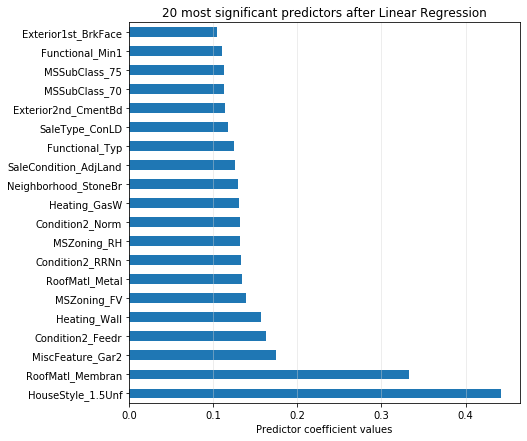

In [61]:
# Define dataframe with predictor coefficients for optimum Ridge model
lnr_df = pd.DataFrame({'Feature': X.columns,
                             'Coef': lnr.named_steps['linearregression'].coef_,
                             'Abs_Coef': np.abs(lnr.named_steps['linearregression'].coef_)})

lnr_df.sort_values('Coef', inplace=True, ascending=False)
# Plot 20 largest coefficients
fig, ax = plt.subplots(figsize=(7,7))
title = '20 most significant predictors after Linear Regression'
lnr_df.Coef[:20].plot(kind='barh', ax=ax)
ax.set_yticklabels(lnr_df.Feature[:20].values)
ax.set_xlabel('Predictor coefficient values')
ax.set_title(title)

# Add a vertical grid to the plot
ax.xaxis.grid(True, linestyle='-', which='both', color='lightgrey', alpha=0.5)
#ax.set_xticks(range(-25000, 30000, 5000), minor=True)
plt.show()

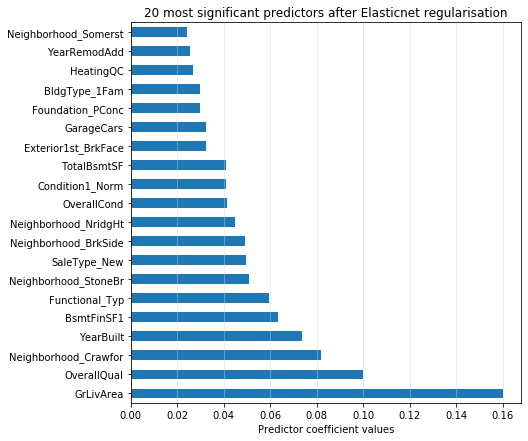

In [62]:
# Define dataframe with predictor coefficients for optimum Ridge model
elasticnet_df = pd.DataFrame({'Feature': X.columns,
                             'Coef': elasticnet.named_steps['elasticnetcv'].coef_,
                             'Abs_Coef': np.abs(elasticnet.named_steps['elasticnetcv'].coef_)})

elasticnet_df.sort_values('Coef', inplace=True, ascending=False)
# Plot 20 largest coefficients
fig, ax = plt.subplots(figsize=(7,7))
title = '20 most significant predictors after Elasticnet regularisation'
elasticnet_df.Coef[:20].plot(kind='barh', ax=ax)
ax.set_yticklabels(elasticnet_df.Feature[:20].values)
ax.set_xlabel('Predictor coefficient values')
ax.set_title(title)

# Add a vertical grid to the plot
ax.xaxis.grid(True, linestyle='-', which='both', color='lightgrey', alpha=0.5)
#ax.set_xticks(range(-25000, 30000, 5000), minor=True)
plt.show()

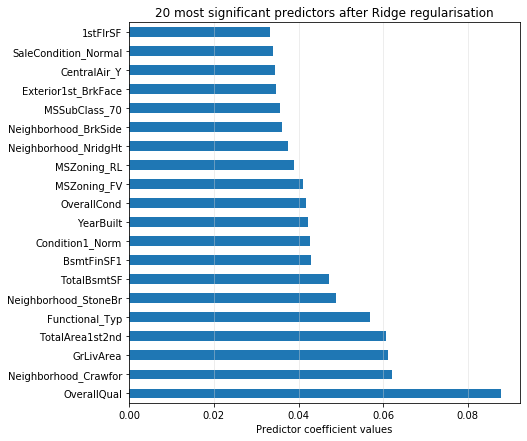

In [63]:
# Define dataframe with predictor coefficients for optimum Ridge model
ridge_df = pd.DataFrame({'Feature': X.columns,
                             'Coef': ridge.named_steps['ridgecv'].coef_,
                             'Abs_Coef': np.abs(ridge.named_steps['ridgecv'].coef_)})

ridge_df.sort_values('Coef', inplace=True, ascending=False)
# Plot 20 largest coefficients
fig, ax = plt.subplots(figsize=(7,7))
title = '20 most significant predictors after Ridge regularisation'
ridge_df.Coef[:20].plot(kind='barh', ax=ax)
ax.set_yticklabels(ridge_df.Feature[:20].values)
ax.set_xlabel('Predictor coefficient values')
ax.set_title(title)

# Add a vertical grid to the plot
ax.xaxis.grid(True, linestyle='-', which='both', color='lightgrey', alpha=0.5)
#ax.set_xticks(range(-25000, 30000, 5000), minor=True)
plt.show()

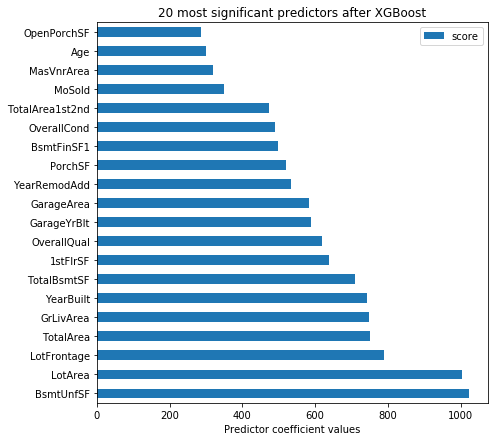

In [64]:
# Define dataframe with predictor coefficients for optimum xgb model
feature_important = xgb.get_booster().get_score(importance_type='weight')

keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.sort_values('score', inplace=True, ascending=False)
fig, ax = plt.subplots(figsize=(7,7))
title = '20 most significant predictors after XGBoost'
ax.set_xlabel('Predictor coefficient values')
ax.set_title(title)
data.iloc[0:20,:].plot(kind='barh', ax=ax)

#### Blending

In [65]:
def blended_predictions(X):
    return ((0.05 * lnr.predict(X)) + \
            (0.15 * ridge.predict(X)) + \
            (0.2 * elasticnet.predict(X)) + \
            (0.05 * svr.predict(X)) + \
            (0.1 * gbr.predict(X)) + \
            (0.1 * xgb.predict(X)) + \
            (0.1 * lgb.predict(X)) + \
           (0.25 * stack.predict(np.array(X))))

In [66]:
blended_score = rmsle(y_valid, blended_predictions(X_valid))

Scores['Blended'] = blended_score
blended_score

0.1121847673971399

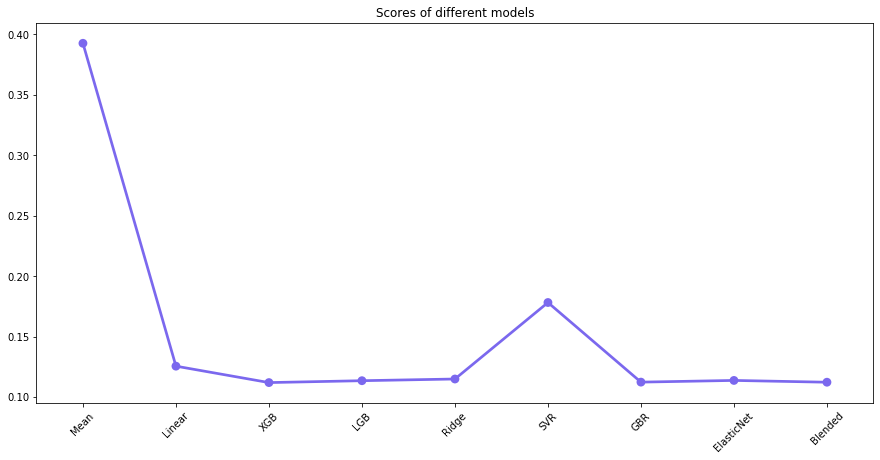

In [67]:
plt.subplots(figsize=(15, 7));plt.title("Scores of different models") 
plt.xticks(rotation=45)
sns.pointplot(x=list(Scores.keys()), y=[score for score in Scores.values()], markers=['o'], linestyles=['-'], color="mediumslateblue")

#### Model scoring with validation set

In [68]:
Scores_valid = {}

In [69]:
scores = rmsle(y_valid, np.full(y_valid.size, y_train.mean(), dtype=float))
print("Mean Predictor\n")
print("Root Mean Square Error (RMSE)", str(scores.mean()))
print("Error Standard Deviation", str(scores.std()))
Scores_valid['Mean_vld'] = scores.mean()

Mean Predictor

Root Mean Square Error (RMSE) 0.40974804965930045
Error Standard Deviation 0.0


In [70]:
lnr_val_score = rmsle(y_valid, lnr.predict(X_valid))

Scores_valid['Linear_vld'] = lnr_val_score
lnr_val_score

0.13290263932310883

In [71]:
xgb_val_score = rmsle(y_valid, xgb.predict(X_valid))

Scores_valid['XGB_vld'] = xgb_val_score
xgb_val_score

0.11783148795775544

In [72]:
lgb_val_score = rmsle(y_valid, lgb.predict(X_valid))

Scores_valid['lgb_vld'] = lgb_val_score
lgb_val_score

0.12479021905154405

In [73]:
ridge_val_score = rmsle(y_valid, ridge.predict(X_valid))

Scores_valid['ridge_vld'] = ridge_val_score
ridge_val_score

0.11698554473293056

In [74]:
svr_val_score = rmsle(y_valid, svr.predict(X_valid))

Scores_valid['svr_vld'] = svr_val_score
svr_val_score

0.16582468386558116

In [75]:
gbr_val_score = rmsle(y_valid, gbr.predict(X_valid))

Scores_valid['gbr_vld'] = gbr_val_score
gbr_val_score

0.11578538602962979

In [76]:
elasticnet_val_score = rmsle(y_valid, elasticnet.predict(X_valid))

Scores_valid['elasticnet_vld'] = elasticnet_val_score
elasticnet_val_score

0.1149284665471227

In [77]:
stack_val_score = rmsle(y_valid, stack.predict(np.array(X_valid)))

Scores_valid['stack_vld'] = stack_val_score
stack_val_score

0.12114883247012136

In [78]:
blended_score = rmsle(y_valid, blended_predictions(X_valid))

Scores_valid['Blended'] = blended_score
blended_score

0.1121847673971399

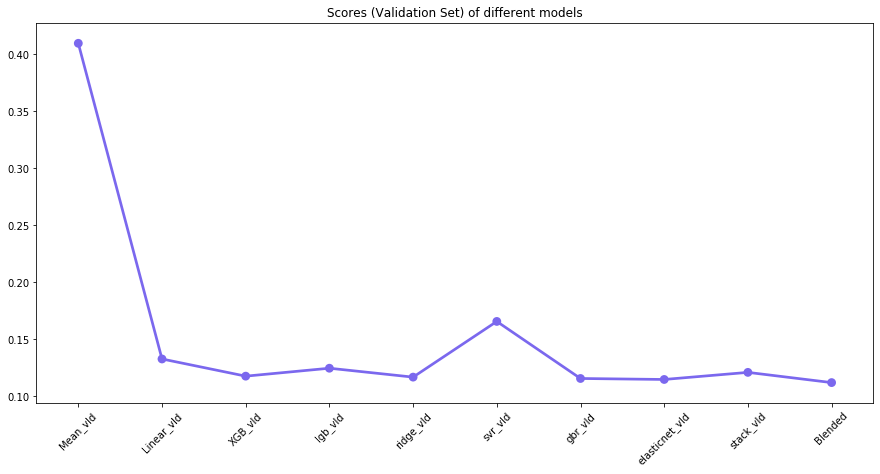

In [79]:
plt.subplots(figsize=(15, 7));plt.title("Scores (Validation Set) of different models") 
plt.xticks(rotation=45)
sns.pointplot(x=list(Scores_valid.keys()), y=[score for score in Scores_valid.values()], markers=['o'], linestyles=['-'], color="mediumslateblue")

## 5. Final Model and Submission

In [80]:
# Read in sample_submission dataframe
submission = pd.read_csv("sample_submission.csv")
submission.shape

(1459, 2)

In [81]:
# Append predictions from blended models
submission.iloc[:,1] = np.floor(rev_y(blended_predictions(test)))
#submission.iloc[:,1] = np.floor(np.full(submission.iloc[:,1].size, rev_y(y.mean()), dtype=float))


In [82]:
submission.to_csv("final_submission.csv", index=False)